<a href="https://colab.research.google.com/github/SkovenForrest/Cellari_project/blob/U-net-architecture/Cellari_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cellario U-Net

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!ls drive/'My Drive'
!ls drive/'My Drive/Gland_dataset' &> /dev/null

drive_path = 'drive/My Drive/Cellari_project'

In [5]:
#seperate the data into training and test and annotated data and load it
#60 test A images
# 20 test B images
# 85 train images

test_images_A = [imread(drive_path +'/Gland_dataset/testA_{}.bmp'.format(i)) for i in range(1,61)] 
test_images_B = [imread(drive_path +'/Gland_dataset/testB_{}.bmp'.format(i)) for i in range(1,21)] 
test_images = test_images_A + test_images_B
print("done with test images")

test_images_A_anno = [imread(drive_path +'/Gland_dataset/testA_{}_anno.bmp'.format(i)) for i in range(1,61)] 
test_images_B_anno = [imread(drive_path +'/Gland_dataset/testB_{}_anno.bmp'.format(i)) for i in range(1,21)]   
test_images_anno = test_images_A_anno + test_images_B_anno 
print("done with test images annotated")

train_images = [imread(drive_path +'/Gland_dataset/train_{}.bmp'.format(i)) for i in range(1,86)] 
print("done with train images")
train_images_anno = [imread(drive_path +'/Gland_dataset/train_{}_anno.bmp'.format(i)) for i in range(1,86)]
print("done with train images annotated")

print("The training set contains {} images".format(len(train_images)))
print("The test set contains {} images".format(len(test_images )))

done with test images
done with test images annotated
done with train images
done with train images annotated
The training set contains 85 images
The test set contains 80 images


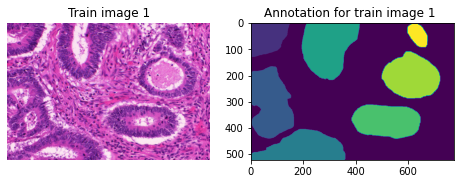

In [6]:
# Plot of the first image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0])
plt.title("Train image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_images_anno[0])
plt.title("Annotation for train image 1 ")
plt.show()

In [7]:
#reshaped image for to make the convolutions easier and normalize the data
test_images = np.array(test_images)
test_images_anno = np.array(test_images_anno)
train_images = np.array(train_images)
train_images_anno = np.array(train_images_anno)


for i in range(0,len(test_images)):
  test_images[i] = resize(test_images[i], output_shape=(522,522), mode='reflect', anti_aliasing=True)

  test_images_mean = np.mean(test_images[i],axis=(0,1))
  test_images_std = np.std(test_images[i],axis=(0,1))

  image = test_images[i]

  image[:, :, 0] = (image[:, :, 0] - test_images_mean[0])/test_images_std[0]
  image[:, :, 1] = (image[:, :, 1] - test_images_mean[1])/test_images_std[1]
  image[:, :, 2] = (image[:, :, 2] - test_images_mean[2])/test_images_std[2]

  test_images[i] = image

  test_images_anno[i] = resize(test_images_anno[i], output_shape=(522,522), mode='reflect', anti_aliasing=True)
  
for i in range(0,len(train_images)):

  train_images[i] = resize(train_images[i], output_shape=(522,522), mode='reflect', anti_aliasing=True)
  train_images_mean = np.mean(train_images[i],axis=(0,1))
  train_images_std = np.std(train_images[i],axis=(0,1))

  image = train_images[i]

  image[:, :, 0] = (image[:, :, 0] - train_images_mean[0])/train_images_std[0]
  image[:, :, 1] = (image[:, :, 1] - train_images_mean[1])/train_images_std[1]
  image[:, :, 2] = (image[:, :, 2] - train_images_mean[2])/train_images_std[2]

  train_images[i] = image
  
  train_images_anno[i] = resize(train_images_anno[i], output_shape=(522,522), mode='reflect', anti_aliasing=True)

print("done")

done


# Build the model

The U-Net architecture


In [8]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, sigmoid, tanh, softmax

In [9]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [104]:

def double_conv(channel_in, channel_out):
  conv = nn.Sequential(
      nn.Conv2d(channel_in, channel_out, kernel_size = 3),
      nn.ReLU(inplace=True),
      nn.Conv2d(channel_out, channel_out, kernel_size = 3),
      nn.ReLU(inplace=True)
  )
  return conv

def image_cropping(x1, x2):
  train_images_cropped = F.interpolate(x1, size= x2.size()[2])
  return train_images_cropped

"""  
def image_cropping(img, desired_img):
  desired_dimensions = desired_img.size()[2]
  current_dimensions = img.size()[2]
  difference = (current_dimensions - desired_dimensions)//2
  start_slice = difference
  end_slice = current_dimensions-difference
  img = img[:, :, start_slice:end_slice, start_slice:end_slice]
  return img
"""

class U_Net(nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()
 
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #convolute the image down 
        self.conv_down_1 = double_conv(3, 64)
        self.conv_down_2 = double_conv(64, 128)
        self.conv_down_3 = double_conv(128, 256)
        self.conv_down_4 = double_conv(256, 512)
        self.conv_down_5 = double_conv(512, 1024)

        #convolute the image up
        self.trans_up_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        self.conv_up_1 = double_conv(1024, 512)

        self.trans_up_2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        self.conv_up_2 = double_conv(512, 256)

        self.trans_up_3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        self.conv_up_3 = double_conv(256, 128)

        self.trans_up_4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        self.conv_up_4 = double_conv(128, 64)

        self.out = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size= 1)



    def forward(self, img):
        x1 = self.conv_down_1(img)
        print("x1",x1.size())
        x2 = self.max_pool(x1)
        x3 = self.conv_down_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.conv_down_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.conv_down_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.conv_down_5(x8)
        print("x9",x9.size())


        x10 = self.trans_up_1(x9)

        crop1 = image_cropping(x7,x10)
        y = torch.cat([x10,crop1])
        x11 = self.conv_up_1(torch.cat([x10,crop1],1))

        x12 = self.trans_up_2(x11)
        crop2 = image_cropping(x5,x12)
        x13 = self.conv_up_2(torch.cat([x12,crop2],1)) 


        x14 = self.trans_up_3(x13)
        crop3 = image_cropping(x3,x14)
        x15 = self.conv_up_3(torch.cat([x14,crop3],1)) 

        x16 = self.trans_up_4(x15)
        crop4 = image_cropping(x1,x16)
        x17 = self.conv_up_4(torch.cat([x16,crop4],1)) 

        print("x17", x17.size())
        output = self.out(x17)
        print("output", output.size())
        return output
  
  
net = U_Net()
net = net.cuda()
#print(net)

In [105]:

# dummy data
rand_img = torch.rand((1,3,522,522))
rand_img = rand_img.cuda()

# test the forward pass
my_nn = U_Net()
my_nn = my_nn.cuda()
result = my_nn(img = rand_img)
print (result)

x1 torch.Size([1, 64, 518, 518])
x9 torch.Size([1, 1024, 24, 24])
x17 torch.Size([1, 64, 324, 324])
output torch.Size([1, 2, 324, 324])
tensor([[[[ 0.0286,  0.0279,  0.0294,  ...,  0.0340,  0.0290,  0.0312],
          [ 0.0298,  0.0260,  0.0241,  ...,  0.0298,  0.0296,  0.0316],
          [ 0.0292,  0.0310,  0.0295,  ...,  0.0308,  0.0295,  0.0353],
          ...,
          [ 0.0301,  0.0311,  0.0293,  ...,  0.0320,  0.0261,  0.0298],
          [ 0.0299,  0.0316,  0.0309,  ...,  0.0303,  0.0278,  0.0274],
          [ 0.0324,  0.0315,  0.0274,  ...,  0.0296,  0.0337,  0.0314]],

         [[-0.0887, -0.0884, -0.0904,  ..., -0.0884, -0.0883, -0.0876],
          [-0.0899, -0.0907, -0.0892,  ..., -0.0862, -0.0899, -0.0928],
          [-0.0876, -0.0908, -0.0895,  ..., -0.0891, -0.0901, -0.0895],
          ...,
          [-0.0925, -0.0880, -0.0893,  ..., -0.0893, -0.0911, -0.0901],
          [-0.0889, -0.0872, -0.0908,  ..., -0.0880, -0.0860, -0.0896],
          [-0.0895, -0.0910, -0.0929,  .

In [65]:

def image_cropping(x1, x2):
  train_images_cropped = F.interpolate(x1, size= x2.size()[2])
  return train_images_cropped


x10 = torch.rand((1,512,48,48))
x7 = torch.rand((1,512,57,57))

result = image_cropping(x7,x10)
print(result.size())

torch.cat([x10,result])




torch.Size([1, 512, 48, 48])


tensor([[[[1.4829e-01, 9.0356e-01, 2.9754e-01,  ..., 1.5248e-01,
           8.2816e-02, 8.6377e-01],
          [5.8691e-02, 7.3501e-01, 8.1505e-01,  ..., 5.6714e-01,
           3.5226e-01, 4.4819e-01],
          [7.6495e-02, 4.1976e-01, 5.6463e-01,  ..., 2.2940e-01,
           3.3988e-01, 9.5395e-01],
          ...,
          [6.8326e-01, 7.1037e-01, 9.5806e-01,  ..., 5.1618e-02,
           2.7761e-01, 7.9332e-01],
          [2.1287e-01, 4.1575e-01, 2.4712e-01,  ..., 6.5895e-01,
           7.0125e-01, 4.0225e-01],
          [9.5668e-01, 3.2430e-01, 7.5625e-02,  ..., 3.9331e-01,
           7.6606e-01, 7.4406e-01]],

         [[5.2942e-02, 7.2582e-01, 2.7752e-02,  ..., 7.2969e-02,
           7.1029e-01, 7.0639e-01],
          [5.8962e-01, 2.0461e-01, 2.0896e-01,  ..., 3.1798e-01,
           4.0504e-01, 7.2552e-01],
          [6.1281e-01, 8.7215e-01, 1.6406e-02,  ..., 8.5508e-01,
           2.1107e-01, 2.8135e-01],
          ...,
          [7.1033e-02, 6.0995e-02, 8.1805e-01,  ..., 1.9509

In [ ]:
rand_img = torch.rand((1,3,138,138))
rand_img2 = torch.rand((1,3,104,104))
img = image_cropping(rand_img,rand_img2)
print(img.size())